- 'Education special needs' and 'International' categorical variables have no relation to target as per chi-squared test and can be dropped as part of feature selection
- All other features have target correlation and can't be dropped
- Train and test come from same distribution as per chi-squared test

In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.preprocessing import LabelEncoder
from sklearn.feature_selection import chi2, SelectKBest
from scipy.stats import chi2_contingency
import re
from matplotlib.ticker import MaxNLocator

/home/bk_anupam/anaconda3/envs/fastai/lib/python3.9/site-packages/pandas/core/computation/expressions.py:21: UserWarning: Pandas requires version '2.8.4' or newer of 'numexpr' (version '2.7.3' currently installed).
  from pandas.core.computation.check import NUMEXPR_INSTALLED
/home/bk_anupam/anaconda3/envs/fastai/lib/python3.9/site-packages/pandas/core/arrays/masked.py:60: UserWarning: Pandas requires version '1.3.6' or newer of 'bottleneck' (version '1.3.2' currently installed).
  from pandas.core import (


In [2]:
import sys
import os
sys.path.append(os.path.abspath("/home/bk_anupam/code/ML/ML_UTILS/"))
import data_utils

In [3]:
df_train = pd.read_csv("./data/train.csv")
df_test = pd.read_csv("./data/test.csv")

In [4]:
def process_col_name(cols_list):
    processed_cols_list = []
    for item in cols_list:
        # Remove round brackets but keep the text inside them
        item_no_brackets = re.sub(r'[\(\)]', '', item)
        # Remove single quotes
        item_no_quotes = item_no_brackets.replace("'", "")
        # Replace forward slash with underscore
        item_no_slash = item_no_quotes.replace('/', '_')
        # Replace spaces with underscores
        item_processed = item_no_slash.replace(' ', '_')        
        # Append to the processed list
        processed_cols_list.append(item_processed)
    return processed_cols_list

In [5]:
train_cols_list = df_train.columns.to_list()
test_cols_list = df_test.columns.to_list()
train_processed_cols_list = process_col_name(train_cols_list)
test_processed_cols_list = process_col_name(test_cols_list)
df_train.columns = train_processed_cols_list
df_test.columns = test_processed_cols_list

In [6]:
df_train.head()

,id,Marital_status,Application_mode,Application_order,Course,Daytime_evening_attendance,Previous_qualification,Previous_qualification_grade,Nacionality,Mothers_qualification,...,Curricular_units_2nd_sem_credited,Curricular_units_2nd_sem_enrolled,Curricular_units_2nd_sem_evaluations,Curricular_units_2nd_sem_approved,Curricular_units_2nd_sem_grade,Curricular_units_2nd_sem_without_evaluations,Unemployment_rate,Inflation_rate,GDP,Target
0,0,1,1,1,9238,1,1,126.0,1,1,...,0,6,7,6,12.428571,0,11.1,0.6,2.02,Graduate
1,1,1,17,1,9238,1,1,125.0,1,19,...,0,6,9,0,0.000000,0,11.1,0.6,2.02,Dropout
2,2,1,17,2,9254,1,1,137.0,1,3,...,0,6,0,0,0.000000,0,16.2,0.3,-0.92,Dropout
3,3,1,1,3,9500,1,1,131.0,1,19,...,0,8,11,7,12.820000,0,11.1,0.6,2.02,Enrolled
4,4,1,1,2,9500,1,1,132.0,1,19,...,0,7,12,6,12.933333,0,7.6,2.6,0.32,Graduate


In [7]:
df_train.dtypes.value_counts()

int64      30
float64     7
object      1
Name: count, dtype: int64

In [70]:
COLS_TO_LEAVE = ["id", "Target", "kfold"]
target_col = 'Target'
cont_features = df_train.dtypes[df_train.dtypes == "float"].index.values.tolist()
int_features = df_train.dtypes[df_train.dtypes == "int"].index.values.tolist()
cat_features = ['Marital_status', 'Application_mode', 
       'Course', 'Daytime_evening_attendance', 'Previous_qualification',
       'Nacionality', 'Mothers_qualification', 'Fathers_qualification',
       'Mothers_occupation', 'Fathers_occupation', 'Displaced',
       'Educational_special_needs', 'Debtor', 'Tuition_fees_up_to_date',
       'Gender', 'Scholarship_holder', 'International']
all_features = [x for x in df_train.columns if x not in COLS_TO_LEAVE]

In [ ]:
le = LabelEncoder()
le.fit(df_train[target_col])
df_train[target_col] = le.transform(df_train[target_col])
list(le.classes_)

In [9]:
from sklearn.decomposition import PCA

pca = PCA()
pca.fit(df_train[all_features])

PCA()

In [11]:
# 99.94% variance is explained by one component alone
print(f"explained variance ratio = {pca.explained_variance_ratio_}")
print(f"number of components = {pca.n_components_}")
print(f"sum explained variance = {pca.explained_variance_ratio_.sum()}")

explained variance ratio = [9.99432792e-01 1.76173968e-04 1.18974253e-04 8.75988917e-05
 6.74603642e-05 3.05757802e-05 1.98281476e-05 1.79305149e-05
 1.51475438e-05 9.33610773e-06 7.72155043e-06 3.80272476e-06
 3.52737646e-06 2.42858868e-06 1.75022321e-06 1.15112198e-06
 1.01327583e-06 7.48180411e-07 5.83839856e-07 4.40233300e-07
 2.73445739e-07 2.04623307e-07 1.20694451e-07 8.13274833e-08
 6.07734785e-08 5.36676169e-08 4.40855522e-08 3.98007646e-08
 3.09047474e-08 3.05615315e-08 2.79344315e-08 1.74304970e-08
 1.65943153e-08 1.17862102e-08 1.14169627e-09 6.70913346e-10]
number of components = 36
sum explained variance = 1.0000000000000002


In [65]:
def plot_embedding_nolegend(embedding, target, title):
    plt.figure(figsize=(10, 8))
    plt.scatter(embedding[:, 0], embedding[:, 1], c=target, cmap='coolwarm', s=5)
    plt.gca().set_aspect('equal', 'datalim')
    plt.title(title)
    plt.show()

In [62]:
# To identify which point corresponds to which class in your scatter plot, you can add a legend 
# that indicates the class labels. This can be done by creating a scatter plot for each class separately 
# and then adding a legend
def plot_embedding(embedding, target, title):
    plt.figure(figsize=(10, 8))
    # Get unique classes in the target
    unique_classes = np.unique(target)

    # Create a scatter plot for each class
    for class_value in unique_classes:
        indices = target == class_value
        plt.scatter(embedding[indices, 0], embedding[indices, 1], s=5, label=f'Class {class_value}')

    plt.gca().set_aspect('equal', 'datalim')
    plt.title(title)
    plt.legend()
    plt.show()

In [13]:
from sklearn.manifold import TSNE

tsne = TSNE(n_components=2)
X_tsne = tsne.fit_transform(df_train[all_features])

Exception ignored on calling ctypes callback function: <function _ThreadpoolInfo._find_modules_with_dl_iterate_phdr.<locals>.match_module_callback at 0x7fc728680040>
Traceback (most recent call last):
  File "/home/bk_anupam/anaconda3/envs/fastai/lib/python3.9/site-packages/threadpoolctl.py", line 400, in match_module_callback
    self._make_module_from_path(filepath)
  File "/home/bk_anupam/anaconda3/envs/fastai/lib/python3.9/site-packages/threadpoolctl.py", line 515, in _make_module_from_path
    module = module_class(filepath, prefix, user_api, internal_api)
  File "/home/bk_anupam/anaconda3/envs/fastai/lib/python3.9/site-packages/threadpoolctl.py", line 606, in __init__
    self.version = self.get_version()
  File "/home/bk_anupam/anaconda3/envs/fastai/lib/python3.9/site-packages/threadpoolctl.py", line 646, in get_version
    config = get_config().split()
AttributeError: 'NoneType' object has no attribute 'split'


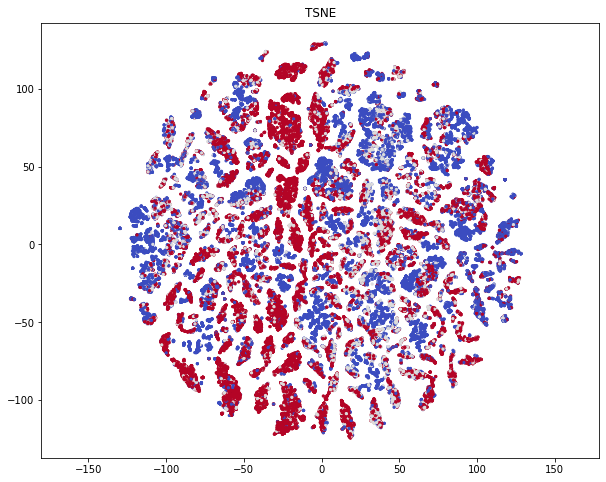

In [66]:
plot_embedding_nolegend(X_tsne.embedding_, df_train[target_col], "TSNE")

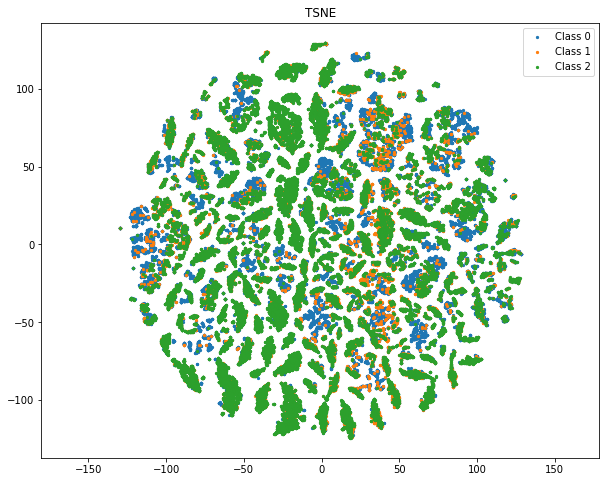

In [63]:
plot_embedding(X_tsne.embedding_, df_train[target_col], "TSNE")

In [27]:
import umap

reducer = umap.UMAP()
X_umap = reducer.fit_transform(df_train[all_features])

OMP: Info #276: omp_set_nested routine deprecated, please use omp_set_max_active_levels instead.
/home/bk_anupam/anaconda3/envs/fastai/lib/python3.9/site-packages/sklearn/manifold/_spectral_embedding.py:285: UserWarning: Graph is not fully connected, spectral embedding may not work as expected.
  warnings.warn(


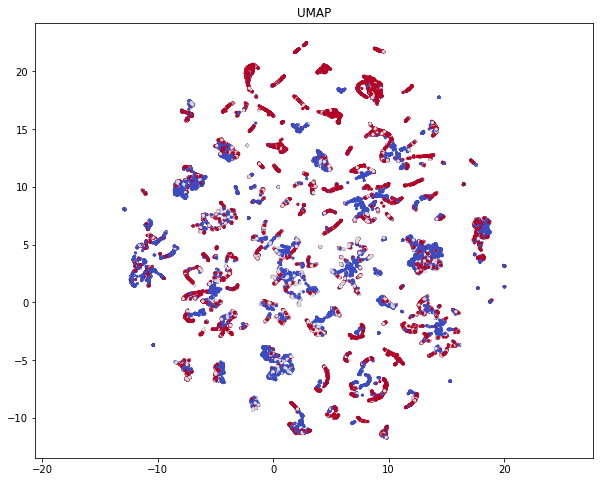

In [67]:
plot_embedding_nolegend(X_umap, df_train[target_col], "UMAP")

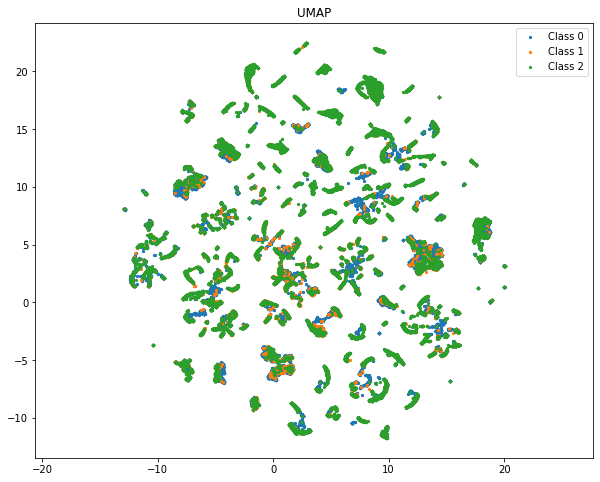

In [64]:
plot_embedding(X_umap, df_train[target_col], "UMAP")

In [68]:
cont_features

['Previous_qualification_grade',
 'Admission_grade',
 'Curricular_units_1st_sem_grade',
 'Curricular_units_2nd_sem_grade',
 'Unemployment_rate',
 'Inflation_rate',
 'GDP']

In [12]:
df_col_info = pd.DataFrame({
    "col_name": df_train.columns,
    "col_unique_count": df_train.nunique().values,
    "col_dtype": df_train.dtypes.values
})
df_col_info.sort_values("col_unique_count", ascending=False)

,col_name,col_unique_count,col_dtype
0,id,76518,int64
32,Curricular_units_2nd_sem_grade,1234,float64
26,Curricular_units_1st_sem_grade,1206,float64
13,Admission_grade,668,float64
7,Previous_qualification_grade,110,float64
12,Fathers_occupation,56,int64
20,Age_at_enrollment,46,int64
11,Mothers_occupation,40,int64
10,Fathers_qualification,39,int64
24,Curricular_units_1st_sem_evaluations,36,int64


In [13]:
df_train.Target.value_counts()/df_train.shape[0]

Target
2    0.474163
0    0.330589
1    0.195248
Name: count, dtype: float64

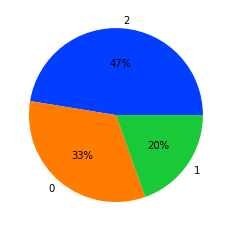

In [14]:
# define Seaborn color palette to use 
palette_color = sns.color_palette('bright') 
  
# plotting data on chart 
plt.pie(df_train.Target.value_counts().values, labels=df_train.Target.value_counts().index.values, colors=palette_color, autopct='%.0f%%') 
  
# displaying chart 
plt.show() 

In [15]:
def chi_square_test(train_df, test_df, column):
    train_counts = train_df[column].value_counts()
    test_counts = test_df[column].value_counts()
    counts_df = pd.DataFrame([train_counts, test_counts], index=['train', 'test']).fillna(0)
    chi2, p, dof, expected = chi2_contingency(counts_df)
    print(f'Chi-square test for {column}: p-value = {p}')
    return p

col_p = {}
for column in cat_features:
    p = chi_square_test(df_train, df_test, column)
    col_p[column] = p

# p-value < 0.05 indicates that the null hypothesis is rejected which means that 
# there is a significant difference between the train and test set to indicate that they come from different distributions

# find items in col_p with p-value < 0.05
significant_cols = [key for key, value in col_p.items() if value < 0.05]
print(f'Columns with significant difference between train and test: {significant_cols}')


Chi-square test for Marital_status: p-value = 0.3054411067524824
Chi-square test for Application_mode: p-value = 0.5747613534808227
Chi-square test for Course: p-value = 0.13223080652277974
Chi-square test for Daytime/evening_attendance: p-value = 0.059212857817048124
Chi-square test for Previous_qualification: p-value = 0.9979632145105526
Chi-square test for Nacionality: p-value = 0.29496058536185965
Chi-square test for Mothers_qualification: p-value = 0.8226070647691084
Chi-square test for Fathers_qualification: p-value = 0.411501899937911
Chi-square test for Mothers_occupation: p-value = 0.7313454205826803
Chi-square test for Fathers_occupation: p-value = 0.5891412921735645
Chi-square test for Displaced: p-value = 0.9346793563674536
Chi-square test for Educational_special_needs: p-value = 0.28310458913588965
Chi-square test for Debtor: p-value = 0.01467058936404247
Chi-square test for Tuition_fees_up_to_date: p-value = 0.39356517871193175
Chi-square test for Gender: p-value = 0.2781

In [16]:
# Determine which categorical variables are not related to target and can be dropped in feature selection
X = df_train[int_features]
y = df_train[target_col]
# Apply chi2 test
chi2_stat, p_values = chi2(X, y)
# Create a DataFrame to display the results
results = pd.DataFrame({
    'Feature': X.columns,
    'Chi2 Stat': chi2_stat,
    'P-value': p_values
})
# features with p-value < 0.05 indicates that the null hypothesis is rejected which means that 
# there feature and target variable are correlated. The strength and direction of relationship is not established by chi2 test
results.sort_values('Chi2 Stat', ascending=False)

,Feature,Chi2 Stat,P-value
4,Course,773646.910875,0.000000e+00
2,Application_mode,141793.384009,0.000000e+00
28,Curricular_units_2nd_sem_approved,90057.781768,0.000000e+00
23,Curricular_units_1st_sem_approved,70342.190672,0.000000e+00
18,Age_at_enrollment,18230.070836,0.000000e+00
27,Curricular_units_2nd_sem_evaluations,16684.361423,0.000000e+00
6,Previous_qualification,13267.307216,0.000000e+00
22,Curricular_units_1st_sem_evaluations,10987.586025,0.000000e+00
17,Scholarship_holder,9511.151909,0.000000e+00
8,Mothers_qualification,8383.362931,0.000000e+00


In [17]:
feature_selector = SelectKBest(chi2, k=10)
X_new = feature_selector.fit_transform(df_train[cat_features], df_train[target_col])
[cat_features[index] for index in feature_selector.get_support(indices=True)]

['Application_mode',
 'Course',
 'Previous_qualification',
 'Mothers_qualification',
 'Mothers_occupation',
 'Fathers_occupation',
 'Debtor',
 'Tuition_fees_up_to_date',
 'Gender',
 'Scholarship_holder']

In [20]:
def plot_feature_target_corr(df, feature_cols, target_col):
    fig, ax = plt.subplots(figsize=(14, 8))
    df = df[feature_cols + [target_col]]
    corr = df.corr()
    target_feature_interaction = corr[target_col].sort_values(ascending=False)
    labels = target_feature_interaction.index.to_list()
    labels.remove(target_col)
    values = target_feature_interaction.values.tolist()
    values.pop(0)
    ax.set_title("Feature target correlation")
    ax.set_xlabel(f"{target_col} correlation")
    ax.set_ylabel("Features")
    ax = sns.barplot(x=values, y=labels, ax=ax, palette="hls")

/tmp/ipykernel_21898/811968328.py:13: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.barplot(x=values, y=labels, ax=ax, palette="hls")


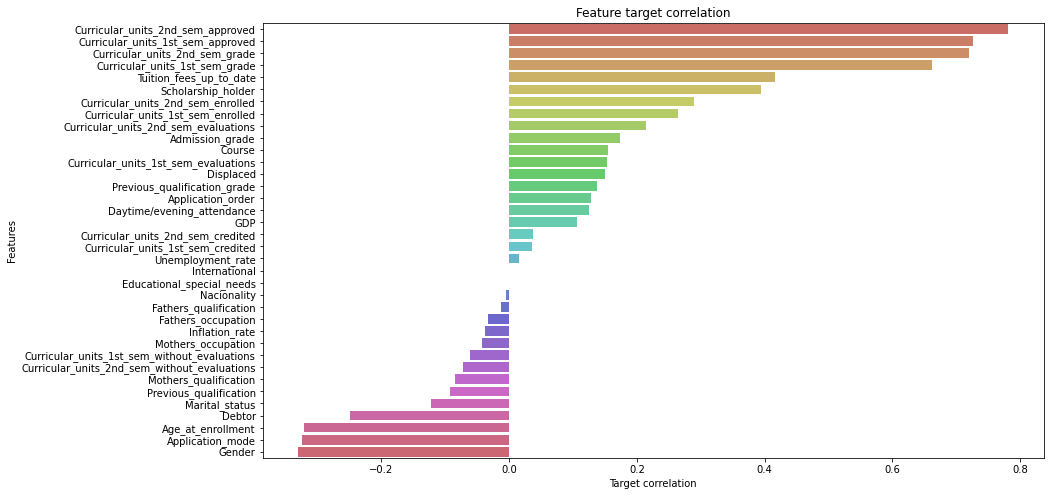

In [21]:
plot_feature_target_corr(df_train, all_features, target_col)

In [91]:
all_features_with_target = all_features + [target_col]
corr = df_train[all_features_with_target].corr().round(2)
target_feature_interaction = corr[target_col].sort_values(ascending=False)
target_feature_interaction

Target                                            1.00
Curricular units 2nd sem (approved)               0.78
Curricular units 1st sem (approved)               0.73
Curricular units 2nd sem (grade)                  0.72
Curricular units 1st sem (grade)                  0.66
Tuition fees up to date                           0.42
Scholarship holder                                0.39
Curricular units 2nd sem (enrolled)               0.29
Curricular units 1st sem (enrolled)               0.26
Curricular units 2nd sem (evaluations)            0.21
Admission grade                                   0.17
Displaced                                         0.15
Course                                            0.15
Curricular units 1st sem (evaluations)            0.15
Previous qualification (grade)                    0.14
Application order                                 0.13
Daytime/evening attendance                        0.12
GDP                                               0.11
Curricular

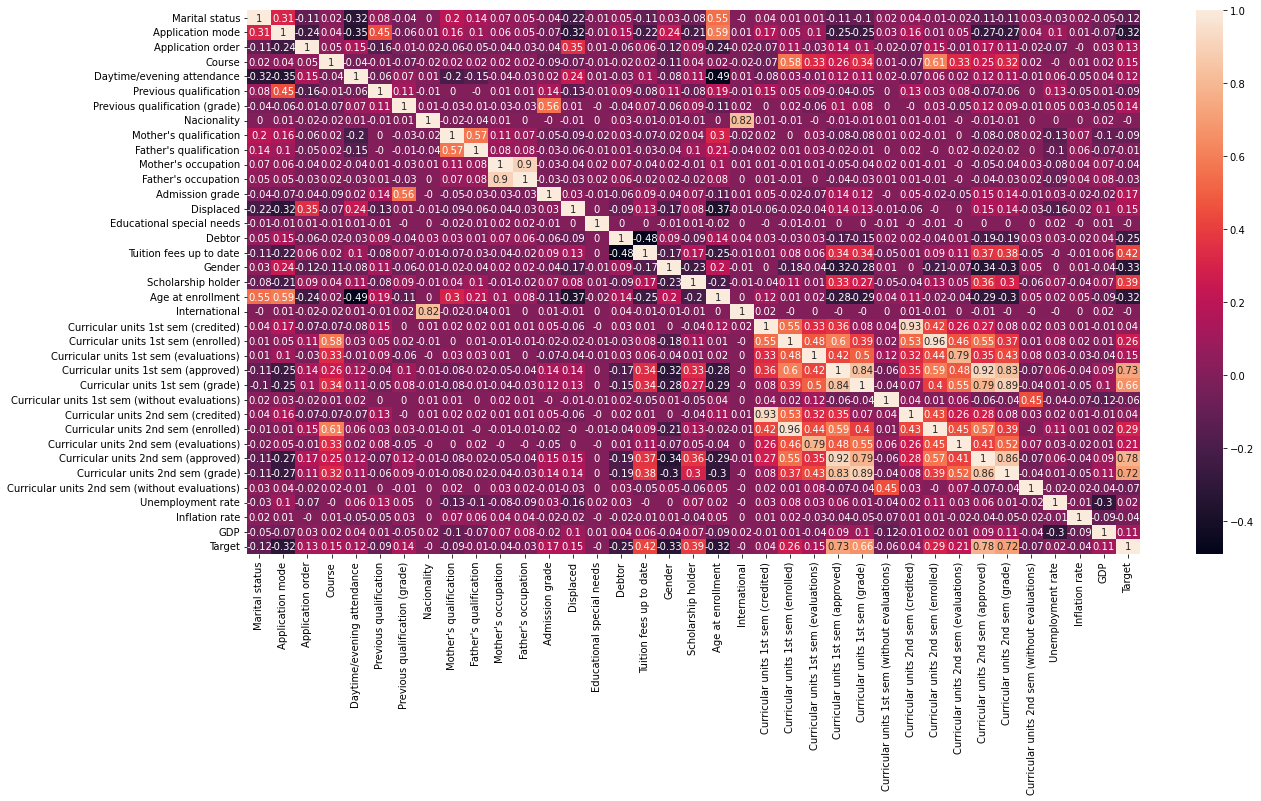

In [93]:
fig, ax = plt.subplots(figsize=(20, 10))
ax = sns.heatmap(corr, xticklabels=corr.columns.values, yticklabels=corr.columns.values, annot=True, ax = ax)

In [23]:
def plot_kde_target(df, cols_float, fig_size):
    # plot the distribution of numerical features . Also check if train and  test data have roughly 
    # the same distribution for numerical features
    n_features = len(cols_float)
    n_rows = (n_features + 1) // 2  # Integer division for ceiling    
    fig, axes = plt.subplots(nrows=n_rows, ncols=2, figsize=fig_size, dpi=100)    
    fig.suptitle('Distribution of continuous features by target', fontsize=12)
    plt.subplots_adjust(hspace=0.3)
    # Loop through features and create subplots
    for i, col_name in enumerate(cols_float):
        row = i // 2
        col = i % 2        
        sns.kdeplot(data=df, x=col_name, hue="Target", fill=True, ax=axes[row, col])                
        axes[row, col].set_ylabel("density")
        axes[row, col].set_xlabel(col_name)                
    # Remove extra subplots if the number of features is odd
    if n_features % 2 == 0:
        fig.delaxes(axes[-1, -1])  # Delete the last subplot if there's an empty one
    fig.tight_layout()
    plt.show()  

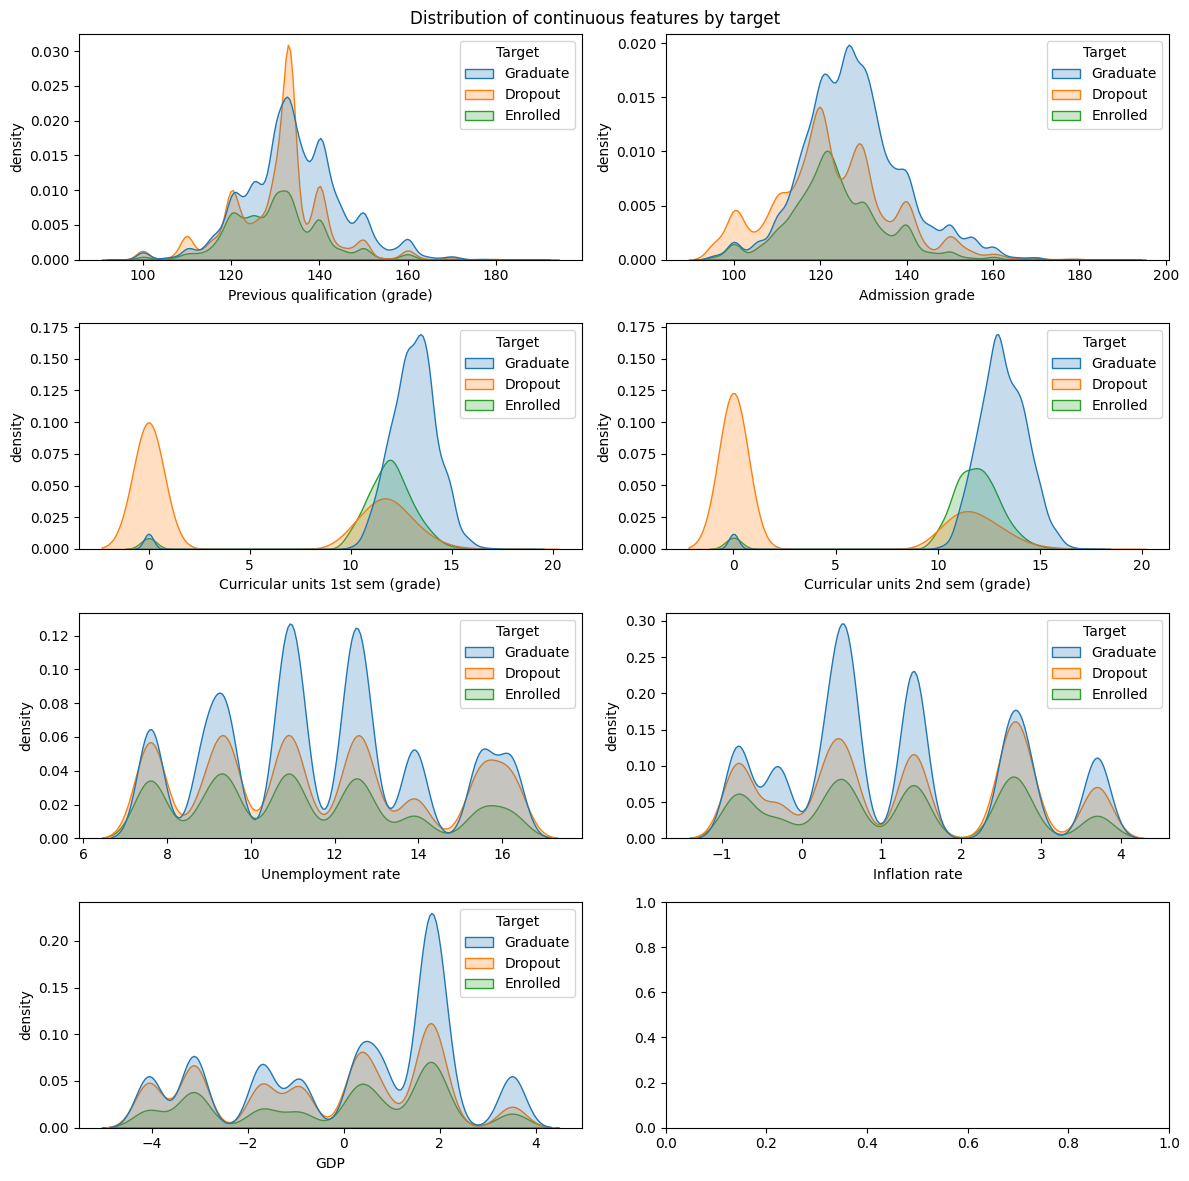

In [24]:
plot_kde_target(df_train, cont_features, fig_size=(12, 12))

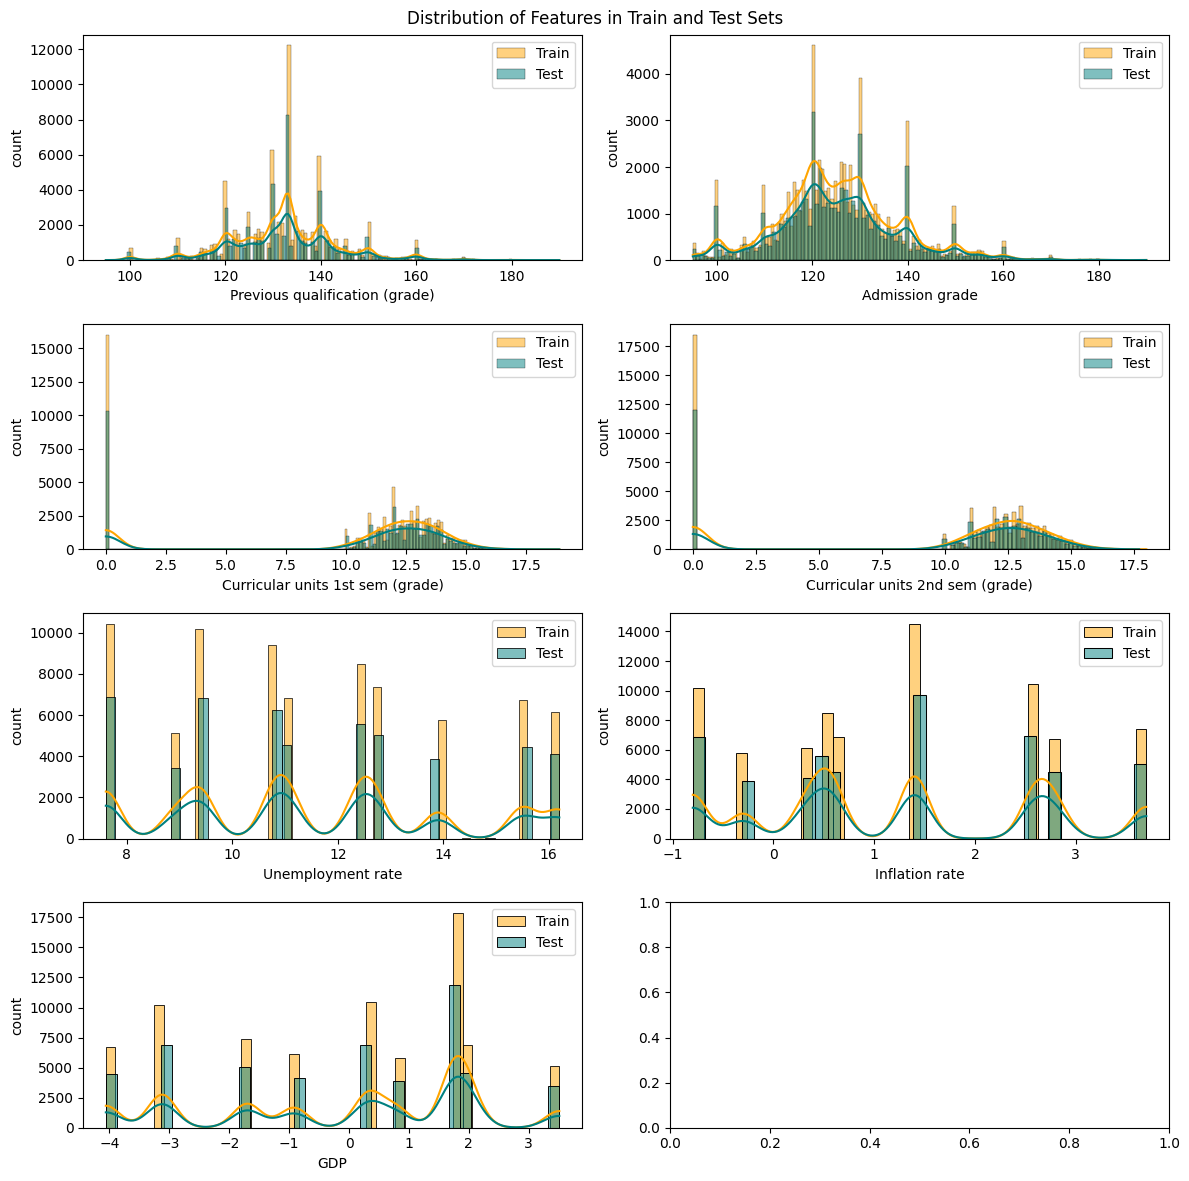

In [19]:
data_utils.plot_feature_distribution(df_train, df_test, cont_features, fig_size=(12, 12))

In [114]:
col = "Marital_status"
target_class_count = df_train.groupby(["Target"]).size().reset_index(name="target_class_count")
count_df = df_train.groupby([col, "Target"]).size().reset_index(name="count")   
count_df = count_df.merge(target_class_count, on="Target")
count_df[f"{col}_ratio"] = count_df["count"] / count_df["target_class_count"] 
count_df = count_df[[col, "Target", f"{col}_ratio"]]
count_df

,Marital_status,Target,Marital_status_ratio
0,1,0,0.858871
1,1,1,0.939491
2,1,2,0.948873
3,2,0,0.117331
4,2,1,0.049197
5,2,2,0.043906
6,3,0,0.000277
7,3,1,0.000134
8,3,2,0.000193
9,4,0,0.020122


In [116]:
df_train.merge(count_df, on=["Marital_status", "Target"])

,id,Marital_status,Application_mode,Application_order,Course,Daytime_evening_attendance,Previous_qualification,Previous_qualification_grade,Nacionality,Mothers_qualification,...,Curricular_units_2nd_sem_enrolled,Curricular_units_2nd_sem_evaluations,Curricular_units_2nd_sem_approved,Curricular_units_2nd_sem_grade,Curricular_units_2nd_sem_without_evaluations,Unemployment_rate,Inflation_rate,GDP,Target,Marital_status_ratio
0,0,1,1,1,9238,1,1,126.0,1,1,...,6,7,6,12.428571,0,11.1,0.6,2.02,2,0.948873
1,1,1,17,1,9238,1,1,125.0,1,19,...,6,9,0,0.000000,0,11.1,0.6,2.02,0,0.858871
2,2,1,17,2,9254,1,1,137.0,1,3,...,6,0,0,0.000000,0,16.2,0.3,-0.92,0,0.858871
3,3,1,1,3,9500,1,1,131.0,1,19,...,8,11,7,12.820000,0,11.1,0.6,2.02,1,0.939491
4,4,1,1,2,9500,1,1,132.0,1,19,...,7,12,6,12.933333,0,7.6,2.6,0.32,2,0.948873
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
76513,76513,1,17,1,9254,1,1,121.0,1,19,...,6,8,5,10.600000,0,13.9,-0.3,0.79,2,0.948873
76514,76514,1,1,6,9254,1,1,125.0,1,1,...,6,9,6,13.875000,0,9.4,-0.8,-3.12,2,0.948873
76515,76515,5,17,1,9085,1,1,138.0,1,37,...,5,8,5,11.400000,1,9.4,-0.8,-3.12,1,0.000870
76516,76516,1,1,3,9070,1,1,136.0,1,38,...,6,0,0,0.000000,0,7.6,2.6,0.32,0,0.858871


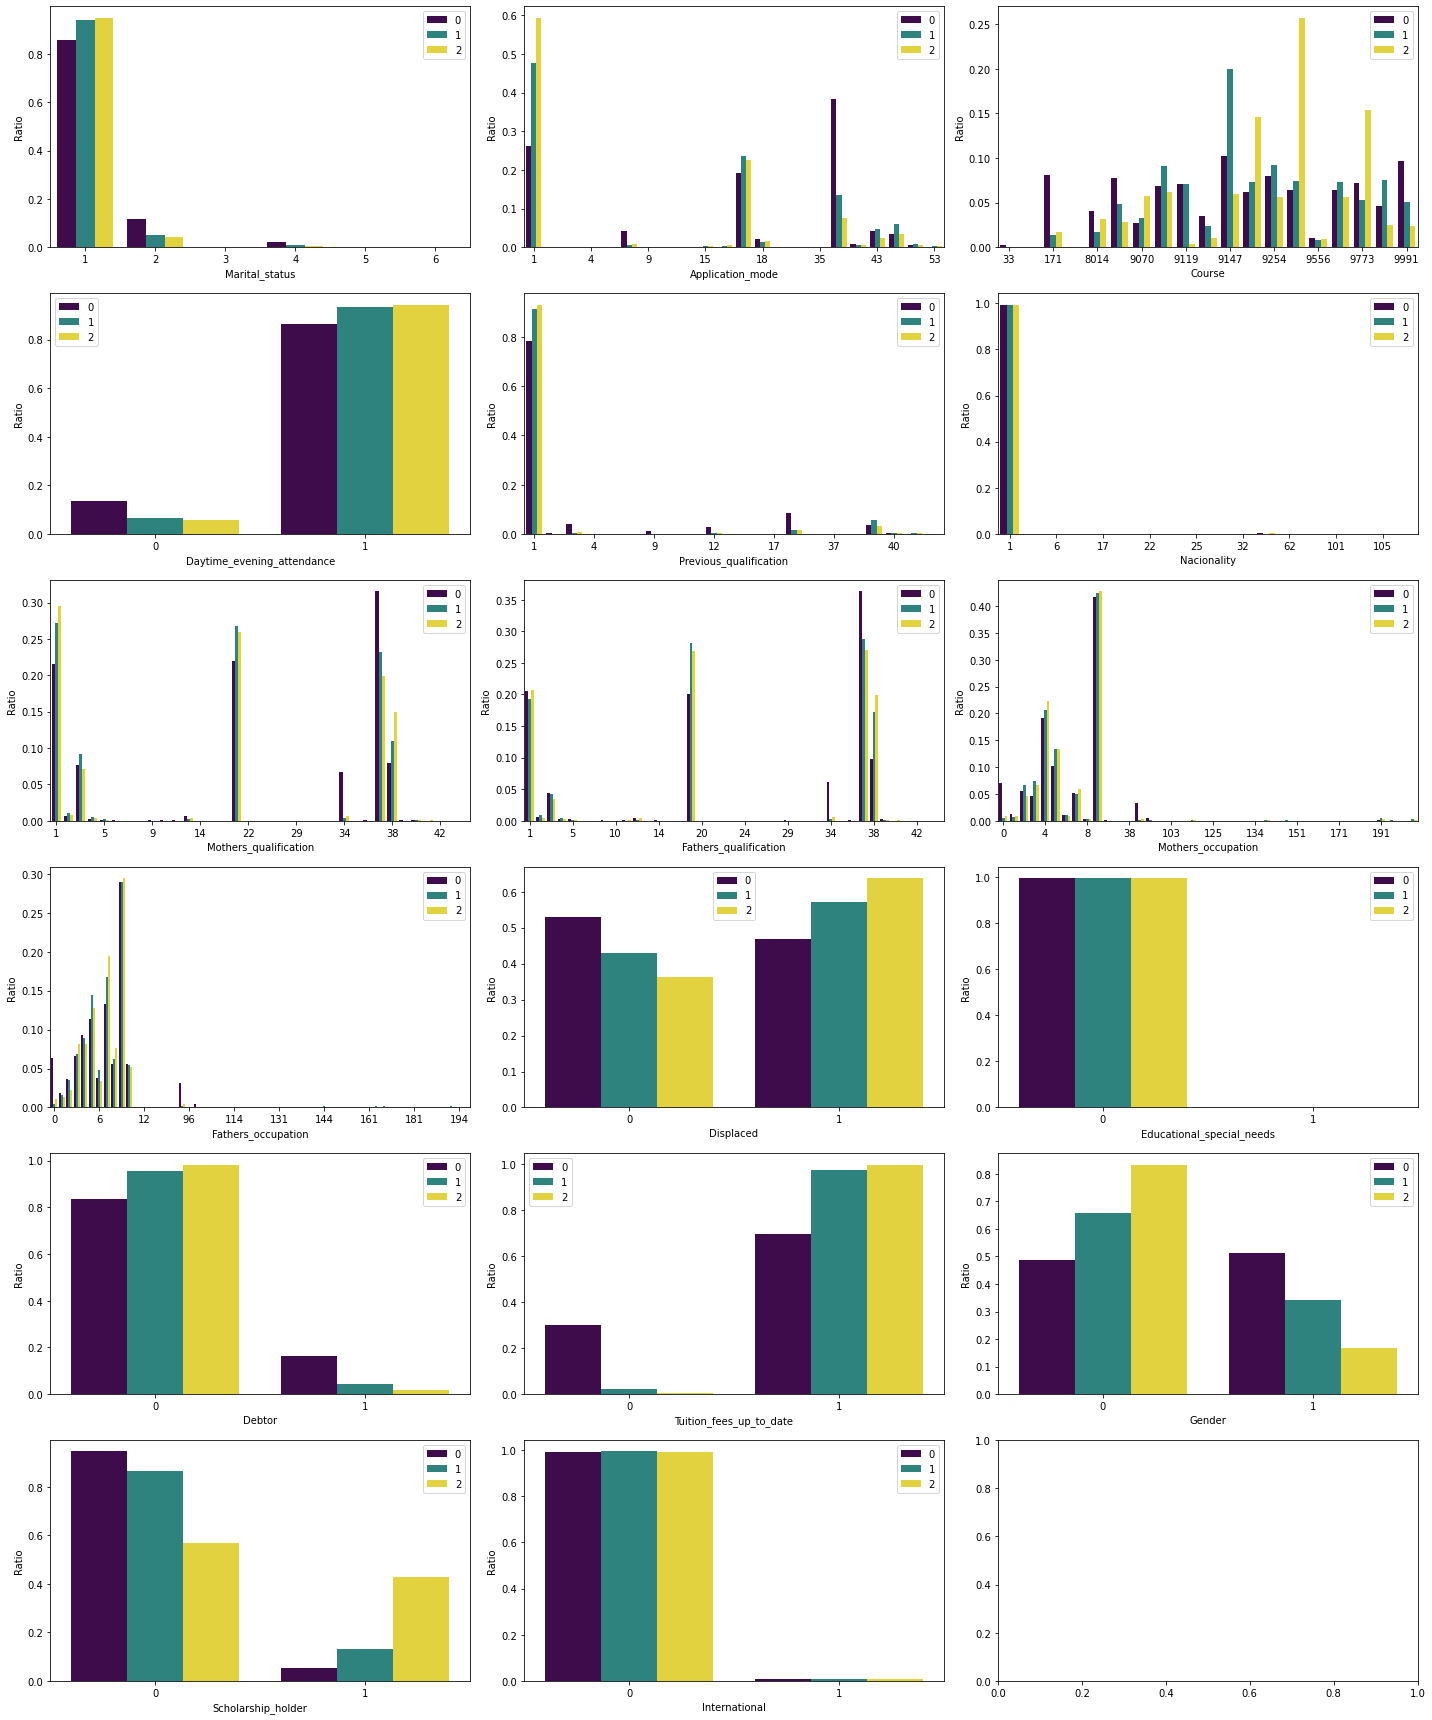

In [123]:
initial_features = cat_features
target_class_count = df_train.groupby(["Target"]).size().reset_index(name="target_class_count")

_, axs = plt.subplots(6, 3, figsize=(20, 24))
for col, ax in zip(initial_features, axs.ravel()):
    count_df = df_train.groupby([col, "Target"]).size().reset_index(name="count")   
    count_df = count_df.merge(target_class_count, on="Target")
    count_df["ratio"] = count_df["count"] / count_df["target_class_count"] 
    sns.barplot(x=col, y="ratio", hue="Target", data=count_df, ax=ax, palette='viridis')
    ax.legend()    
    ax.set_ylabel("Ratio")
    #ax.set_title(col)
    ax.xaxis.set_major_locator(MaxNLocator(integer=True)) # only integer labels
plt.tight_layout()
plt.show()